## 1. Load data and modules
## 2. Creating a Class-Conditioned UNet

- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)`via an embedding layer
- Concatenate this information as extra channels for the internal UNet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the UNet to get the final prediction

In this example I've set the class_emb_size to 4, but this is completely arbitrary and you could explore having it size 1 (to see if it still works), size 10 (to match the number of classes), or replacing the learned nn.Embedding with a simple one-hot encoding of the class label directly.
## 3. Sampling

In [2]:
# %pip install -q diffusers

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms as transforms

from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
import os
import pandas as pd


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## 加载数据

In [4]:
# 检查一个图片格式
img_path = "Dfinetune/test/HF_Sava_000468a_20220614_60x.x_9438.y_38379.png"
# 打开图片
img = Image.open(img_path)
print("分辨率:", img.size)  # (宽, 高)
print("色彩:", img.mode)   # RGB or L(灰度)

分辨率: (186, 126)
色彩: L


In [5]:
class DiatomDataset(Dataset):
    def __init__(self, split_csv, label_csv, root_dir, transform=None):
        """
        Args:
            split_csv (str): train.csv/test.csv 路径
            label_csv (str): label.csv 路径
            root_dir (str): 图片所在文件夹路径 (train/ 或 test/)
            transform (callable, optional): 图像转换pipeline
        """
        # 加载文件名列表
        self.file_list = pd.read_csv(split_csv, header=None, names=['filename'])
        
        # 加载标签映射
        label_df = pd.read_csv(label_csv, sep=",", header=None, names=["filename", "label"])
        self.label_map = dict(zip(label_df.filename, label_df.label))
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 获取文件名和标签
        img_name = self.file_list.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        # 加载图像
        image = Image.open(img_path)
        # 类型转换(暂时不需要)
        # image = Image.open(img_path).convert("L")  # 彩色图.convert("RGB")
        
        # 查找标签
        if img_name not in self.label_map:
            raise ValueError(f"找不到标签: {img_name} 在 labels.csv")
        label = int(self.label_map[img_name])
        
        # 预处理
        if self.transform:
            image = self.transform(image)
        elif self.transform1:
            image = self.transform1(image)
        elif self.transform2:
            image = self.transform2(image)
        return image, label


In [6]:
# 图像处理pipeline
# 1.简单缩放
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # rgb
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2.padding
transform1 = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Pad(padding=(0, (128 - img.size[1]) // 2)),  # 高度补齐
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 3.裁剪缩放
transform2 = transforms.Compose([
    transforms.Lambda(lambda img: transforms.CenterCrop(min(img.size))(img)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 路径变量
train_csv = "Dfinetune/train.csv"
test_csv  = "Dfinetune/test.csv"
label_csv = "Dfinetune/labels.csv"
train_root = "Dfinetune/train"
test_root  = "Dfinetune/test"

# 数据集和加载器
train_set = DiatomDataset(train_csv, label_csv, train_root, transform=transform2)
test_set  = DiatomDataset(test_csv,  label_csv, test_root,  transform=transform2)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False)


Batch shape: torch.Size([8, 1, 128, 128])
Labels: tensor([27, 26,  3,  7,  2, 29, 30,  6])


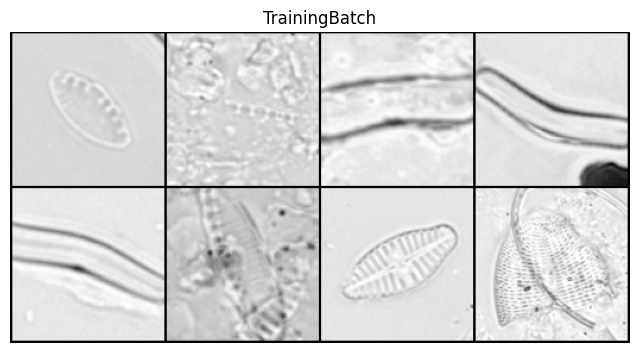

In [7]:
# 获取一个 batch, 验证加载
x, y = next(iter(train_loader))
print("Batch shape:", x.shape)
print("Labels:", y)

# 可视化
grid_img = torchvision.utils.make_grid(x, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("TrainingBatch")
plt.axis('off')
plt.show()

## 1. create UNet2D with CrossAttention

In [8]:
class UNet2D_CrossAttn(nn.Module):
    def __init__(self, num_classes, class_emb_size=8):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.unet = UNet2DModel(
            sample_size=128,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
            cross_attention_dim=class_emb_size,
            class_embed_type="identity"
        )

    def forward(self, x, class_label, timestep):
        class_emb = self.class_emb(class_label)  # [B, class_emb_size]
        return self.unet(x, timestep, encoder_hidden_states=class_emb).sample      

## 2. 训练

In [9]:
from torch.cuda.amp import GradScaler, autocast
from torch import amp
# 创建 scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [10]:
# Redefine dataloader with bigger batch size
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

# Network, loss, optimizer
net = UNet2D_CrossAttn(num_classes=36, class_emb_size=64).to(device)

loss_fn = nn.MSELoss()
# The optimizer
# opt = torch.optim.Adam(net.parameters(), lr=1e-3)
opt = torch.optim.AdamW(net.parameters(), lr=1e-4)  # AdamW 
scaler = amp.GradScaler()  # For AMP

losses = []
n_epochs = 10
best_loss = float('inf')

for epoch in range(n_epochs):
    # net.train()
    for x, y in tqdm(train_dataloader):
        x = x.to(device) * 2 - 1
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Backprop and update the params:
        opt.zero_grad()
        with amp.autocast(device_type="cuda"):  # AMP
            pred = net(noisy_x, timesteps, y)
            loss = loss_fn(pred, noise)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"Epoch {epoch+1}/{n_epochs} | Avg Loss: {avg_loss:.6f} | GPU Mem: {torch.cuda.memory_allocated()//1e6} MB")
    
    torch.save(net.state_dict(), f"xattn_checkpoints/checkpoint_epoch_{epoch+1}.pth")
    # 如果当前 loss 更好，就保存
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(net.state_dict(), "xattn_checkpoints/best_model.pth")
        print(f"Saved new best model at epoch {epoch+1} with loss {avg_loss:.6f}")
    
    
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()

TypeError: UNet2DModel.__init__() got an unexpected keyword argument 'cross_attention_dim'

## 3. 采样和生成

In [61]:
# 替换为 DDIMScheduler 或 DPMSolverMultistepScheduler
from diffusers import DDIMScheduler, DPMSolverMultistepScheduler
noise_scheduler_ddim = DDIMScheduler.from_config(noise_scheduler.config) # 50步骤
noise_scheduler_dpm = DPMSolverMultistepScheduler.from_config(noise_scheduler.config) #20-30步
noise_scheduler_ddim.set_timesteps(50)

In [62]:
# Prepare random x to start from, plus desired labels y
num_classes = 36
samples_per_class = 8  # 每类生成8张
x = torch.randn(num_classes * samples_per_class, 1, 128, 128).to(device)
y = torch.tensor([[i] * samples_per_class for i in range(num_classes)]).flatten().to(device)

# Reverse diffusion (sampling loop)
for t in tqdm(noise_scheduler_ddim.timesteps):
    with torch.no_grad():
        residual = net(x, t, y)  # 条件在 class label
        print(residual.shape)
    x = noise_scheduler.step(residual, t, x).prev_sample

# Postprocess to [0, 1]
samples = (x.detach().cpu().clip(-1, 1) + 1) / 2

# Show grid of generated images
grid = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.figure(figsize=(15, 30))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Generated Samples (Conditioned on Class Labels)")
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([288, 64, 128, 128])


IndexError: index 0 is out of bounds for dimension 0 with size 0